# True SVG Policy Optimization

In [1]:
from __future__ import annotations

from typing import Optional

import lqsvg.experiment.utils as utils
import lqsvg.torch.named as nt
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
from lqsvg.envs import lqr
from lqsvg.envs.lqr.gym import LQGGenerator
from lqsvg.policy.modules import TVLinearFeedback
from lqsvg.policy.modules.utils import stabilizing_policy
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from torch import Tensor
from tqdm.auto import tqdm, trange

## Environment generation

In what follows we consider **stationary dynamics**: $\mathbf{F}_t, \mathbf{f}_t, \mathbf{\Sigma}_t = \mathbf{F}, \mathbf{f}, \mathbf{\Sigma}, \forall t\in\mathcal{T}$.
Where
$$
\mathbf{F} = \begin{bmatrix} \mathbf{A} & \mathbf{B} \end{bmatrix}, \\
\mathbf{A} \in \mathbb{R}^{|\mathcal{S}|\times |\mathcal{S}|}, \mathbf{B} \in \mathbb{R}^{|\mathcal{S}|\times |\mathcal{A}|}
$$

In [2]:
generator = LQGGenerator(
    n_state=2,
    n_ctrl=2,
    horizon=10,
    seed=123,
    stationary=True,
    passive_eigval_range=(0.5, 1.5),
    controllable=True,
    transition_bias=False,
    rand_trans_cov=False,
    rand_init_cov=False,
    cost_linear=False,
    cost_cross=False,
)

## Quadratic State-value

$$
        V^\mu(\mathbf{s}, t) = {\tfrac12} \mathbf{s}^\intercal\mathbf{V}_t\mathbf{s} + \mathbf{v}_t^\intercal\mathbf{s} + v_t, \quad t\in\mathcal{T}^+ \,,
$$

In [3]:
class ValueFn(nn.Module):
    def __init__(self, quadratic: lqr.Quadratic, timestep: int = 0):
        super().__init__()
        V, v, c = (x.select("H", timestep) for x in quadratic)
        self.register_buffer("V", V)
        self.register_buffer("v", nt.vector_to_matrix(v))
        self.register_buffer("c", nt.scalar_to_matrix(c))
        assert len(self.V.shape) == len(self.v.shape) == len(self.c.shape) == 2, (
            self.V.shape,
            self.v.shape,
            self.c.shape,
        )

    def symeig(self) -> (Tensor, Tensor):
        return torch.symeig(nt.unnamed(self.V), eigenvectors=True)

    def forward(self, state: Tensor):
        """Calculate optimal state-value.

        May be used with batched states.
        """
        s = nt.vector_to_matrix(state)
        value = nt.transpose(s) @ self.V @ s / 2 + nt.transpose(self.v) @ s + self.c
        return nt.matrix_to_scalar(value)

    def min(self):
        Vinv = nt.unnamed(self.V).inverse()
        return nt.matrix_to_vector(-Vinv @ self.v)

    def expected(self, init: lqr.GaussInit):
        """Expected cost given mean and covariance matrix of the initial state.

        https://en.wikipedia.org/wiki/Quadratic_form_(statistics)#Expectation.
        """
        mean = nt.vector_to_matrix(init.mu)
        cov = init.sig
        value = (
            nt.scalar_to_matrix(nt.trace(cov @ self.V)) / 2
            + nt.transpose(mean) @ self.V @ mean
            + nt.transpose(self.v) @ mean
            + self.c
        )
        return nt.matrix_to_scalar(value)

    def plot_3d(self, ax, mean: Optional[Tensor] = None, amp: float = 10):
        if mean is None:
            mean = self.min().detach().numpy()
        else:
            mean = mean.detach().numpy()

        xrange = np.linspace(mean[0] - amp, mean[0] + amp, num=100)
        yrange = np.linspace(mean[1] - amp, mean[1] + amp, num=100)
        xbatch, ybatch = np.meshgrid(xrange, yrange)
        assert xbatch.shape == ybatch.shape == (100, 100)

        init_states = np.stack([xbatch, ybatch], axis=-1).reshape((-1, 2))
        init_states = torch.from_numpy(init_states).float().refine_names("B", "R")
        assert init_states.shape == (10000, 2), init_states.shape

        init_values = self(init_states).detach().numpy()
        assert init_values.shape == (10000,), init_values.shape

        init_values = init_values.reshape(xbatch.shape)
        ax.plot_surface(xbatch, ybatch, init_values, cmap=cm.coolwarm)

        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_zlabel("value")

# Exact methods
---
## LQG control

<img src="images/LQG - Control.png" width=800>

In [4]:
def print_solution(policy, qval, vval):
    K, k = policy
    Q, q, qc = qval
    V, v, vc = vval

    print(
        f"""
    Policy:
        K: {K.shape}, {K.names}
        k: {k.shape}, {k.names}
    """
    )

    print(
        f"""
    Q-value:
        Q: {Q.shape}, {Q.names}
        q: {q.shape}, {q.names}
        const: {qc.shape}, {qc.names}
    """
    )

    print(
        f"""
    V-value:
        V: {V.shape}, {V.names}
        V: {v.shape}, {v.names}
        const: {vc.shape}, {vc.names}
    """
    )

In [5]:
dynamics, cost, init = generator(n_batch=None)
lqg_control = lqr.NamedLQGControl(
    generator.n_state, generator.n_ctrl, generator.horizon
)
pistar, qstar, vstar = lqg_control(dynamics, cost)
print_solution(pistar, qstar, vstar)


    Policy:
        K: torch.Size([10, 2, 2]), ('H', 'R', 'C')
        k: torch.Size([10, 2]), ('H', 'R')
    

    Q-value:
        Q: torch.Size([10, 4, 4]), ('H', 'R', 'C')
        q: torch.Size([10, 4]), ('H', 'R')
        const: torch.Size([10]), ('H',)
    

    V-value:
        V: torch.Size([11, 2, 2]), ('H', 'R', 'C')
        V: torch.Size([11, 2]), ('H', 'R')
        const: torch.Size([11]), ('H',)
    


/Users/angelolovatto/Library/Caches/pypoetry/virtualenvs/lqsvg-kEsPsxvA-py3.8/lib/python3.8/site-packages/torch/tensor.py:758: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:934.)
  return super(Tensor, self).refine_names(names)


In [6]:
vstar_fn = ValueFn(vstar)
print(vstar_fn.V)
print(vstar_fn.v)
print(vstar_fn.c)

tensor([[ 2.4339, -3.0686],
        [-3.0686,  6.8353]], names=('R', 'C'))
tensor([[0.],
        [0.]], names=('R', 'C'))
tensor([[31.5925]], names=('R', 'C'))


### Optimal value for best initial state
$$
\begin{align}
\mathbf{s}_{min} 
&= \arg\min_{\mathbf{s}} V^\star(\mathbf{s}, 0) \\
&= \arg\min_{\mathbf{s}} \mathbf{s}^\intercal \mathbf{V}_0^\star \mathbf{s} + {\mathbf{v}_0^\star}^\intercal \mathbf{s} + v_0^\star \\
&= -{\mathbf{V}_0^\star}^{-1} \mathbf{v}_0^\star \\
\end{align}
$$

In [7]:
minimum = vstar_fn.min()
print(
    f"""
    Best initial state: {minimum}
    Best initial value: {vstar_fn(minimum)}
"""
)


    Best initial state: tensor([0., 0.], names=('R',))
    Best initial value: 31.592487335205078



### Optimal expected initial state value
$$
\mathbb{E}_{\mathbf{s}\sim\rho} \left[ V^{\star}(\mathbf{s}, 0) \right]
= \text{Tr}(\mathbf{V}_0\mathbf{\Sigma}_0) + \mathbf{\mu}_0^\intercal \mathbf{V}_0 \mathbf{\mu}_0 + \mathbf{v}_0^\intercal \mathbf{\mu}_0 + v_0
$$

In [8]:
print(
    f"""
    Mean: {init.mu}
    Covariance: {init.sig}
    Expected value: {vstar_fn.expected(init)}
"""
)


    Mean: tensor([0., 0.], names=('R',))
    Covariance: tensor([[1., 0.],
        [0., 1.]], names=('R', 'C'))
    Expected value: 36.22709655761719



### Optimal value for each initial state

In [9]:
def large_fig(scale: float=2.0, cols: int = 1):
    fig = plt.figure(figsize=[scale * 6.4, scale * cols * 4.8])
    return fig

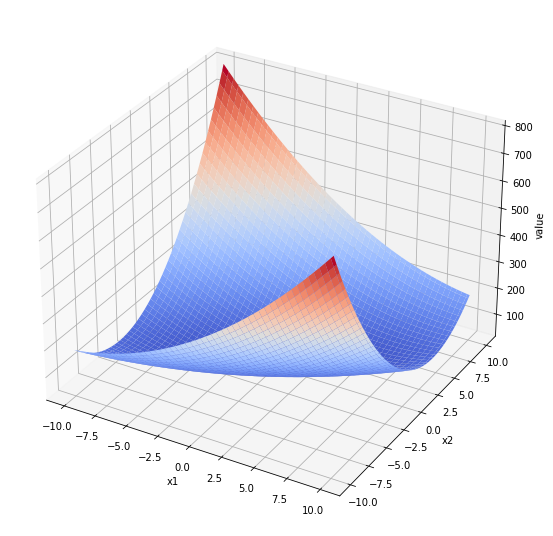

In [10]:
fig = large_fig()
ax = fig.add_subplot(projection="3d")
vstar_fn.plot_3d(ax, mean=init.mu)
# plt.savefig("navigation2d_value.png")
plt.show()

In [11]:
print(vstar_fn.symeig())

torch.return_types.symeig(
eigenvalues=tensor([0.8584, 8.4108]),
eigenvectors=tensor([[-0.8896, -0.4567],
        [-0.4567,  0.8896]]))


## LQG prediction (Policy Evaluation)

<img src="images/LQG - Prediction.png" width=800>

In [12]:
lqg_prediction = lqr.NamedLQGPrediction(
    generator.n_state, generator.n_ctrl, generator.horizon
)

## Time-varying linear policy

A time-varying linear policy is a mapping $\mu_\theta: \mathcal{S}\times\mathcal{T} \mapsto \mathcal{A}$ such that
$$
    \mu_\theta(\mathbf{s}, t) = \mathbf{K}_t \mathbf{s} + \mathbf{k}_t
    \,,
$$
where $\mathbf{K}_t \in \mathbb{R}^{d\times n}$, $\mathbf{k}_t \in \mathbb{R}^d$ and $\theta = \{\mathbf{K}_t, \mathbf{k}_t\}_{t\in\mathcal{T}}$.

## Stabilizing policies

We generate policies for stationary LQGs by computing $\mathbf{K}$ such that
$$
    \text{eig}(\mathbf{A} + \mathbf{BK}) \sim \mathcal{U}\left( [-1, 1]^{|\mathcal{S}|} \right),
$$
where $\text{eig}$ returns the eigenvalues of a matrix.

In [13]:
policy = stabilizing_policy(dynamics, rng=generator._rng)

_, vval = lqg_prediction(policy, dynamics, cost)
vval_fn = ValueFn(vval)
min_state = vval_fn.min()
print(
    f"""
    V: {vval_fn.V}
    v: {vval_fn.v}
    c: {vval_fn.c}
    
    min state: {min_state}
    min value: {vval_fn(min_state)}
"""
)


    V: tensor([[ 22.7090, -84.1221],
        [-84.1220, 567.7589]], names=('R', 'C'))
    v: tensor([[0.],
        [0.]], names=('R', 'C'))
    c: tensor([[2482.4080]], names=('R', 'C'))
    
    min state: tensor([0., 0.], names=('R',))
    min value: 2482.407958984375



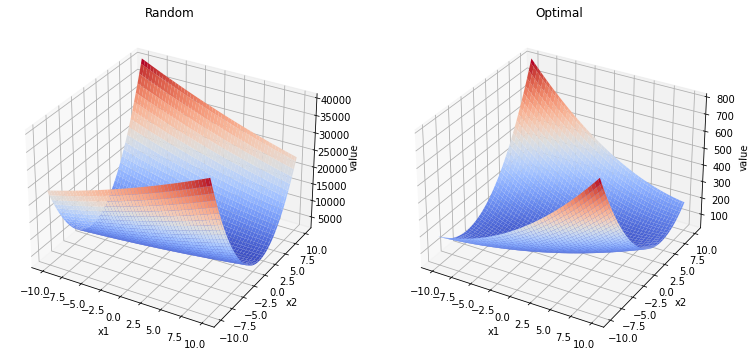

In [14]:
fig = large_fig(cols = 2)
ax = fig.add_subplot(1, 2, 1, projection="3d")
vval_fn.plot_3d(ax, mean=init.mu)
ax.set_title("Random")

ax = fig.add_subplot(1, 2, 2, projection="3d")
vstar_fn.plot_3d(ax, mean=init.mu)
ax.set_title("Optimal")

# plt.savefig("navigation2d_value.png")
plt.show()

In [15]:
print("Random:")
print(vval_fn.symeig())
print("Optimal:")
print(vstar_fn.symeig())

Random:
torch.return_types.symeig(
eigenvalues=tensor([ 10.0211, 580.4468]),
eigenvectors=tensor([[-0.9888, -0.1491],
        [-0.1491,  0.9888]]))
Optimal:
torch.return_types.symeig(
eigenvalues=tensor([0.8584, 8.4108]),
eigenvectors=tensor([[-0.8896, -0.4567],
        [-0.4567,  0.8896]]))


## Policy learning via true value gradients

LQG prediction can be seen as a function mapping policy parameters (with the dynamics kept constant) to value function coefficients:
$$
\left( \mathbf{Q}, \mathbf{q}, q, \mathbf{V}, \mathbf{v}, v \right) = \text{LQGPrediction}(\theta)
$$

Thus, we can write each coeficient as a function of policy parameters. For example, the value function for a policy $\mu_\theta$ would be:
$$
V^\mu(\mathbf{s}, t) = \tfrac12 \mathbf{s}^\intercal \mathbf{V}_t(\theta) \mathbf{s} + \mathbf{v}_t(\theta)^\intercal \mathbf{s} + v_t(\theta)
$$

We can then express policy performance as a direct function of policy parameters:
$$
\begin{align}
J(\theta) 
    &= \mathbb{E}_{\mathbf{s}\sim\rho} \left[ \tfrac12 \mathbf{s}^\intercal \mathbf{V}_0(\theta) \mathbf{s} + \mathbf{v}_0(\theta)^\intercal \mathbf{s} + v_0(\theta) \right] \\
    &= \text{Tr}(\mathbf{V}_0(\theta)\mathbf{\Sigma}_0) + \mathbf{\mu}_0^\intercal \mathbf{V}_0(\theta) \mathbf{\mu}_0 + \mathbf{v}_0(\theta)^\intercal \mathbf{\mu}_0 + v_0(\theta)
\end{align}
$$

In [16]:
class TVLFLoss(nn.Module):
    def __init__(
        self,
        dynamics: lqr.LinDynamics,
        cost: lqr.QuadCost,
        init: lqr.GaussInit,
    ):
        super().__init__()
        n_state, n_ctrl, horizon = lqr.dims_from_dynamics(dynamics)
        self.predict = lqr.NamedLQGPrediction(n_state, n_ctrl, horizon)
        self.dynamics = dynamics
        self.cost = cost
        self.init = init

    def forward(self, policy: lqr.Linear):
        _, vval = self.predict(policy, self.dynamics, self.cost)
        vval_fn = ValueFn(vval)
        cost = vval_fn.expected(self.init)
        return cost

In [18]:
loss = TVLFLoss(dynamics, cost, init)(policy)
print("Random policy loss:", loss)

Random policy loss: tensor(2777.6418)


Finally, since the value function coefficients are differentiable functions of the policy parameters, we can optimize the latter for better performance via gradient ascent
$$
\theta \gets \theta + \alpha \nabla_{\theta} J(\theta)
$$

In [23]:
def test_true_svg():
    n_state, n_ctrl, horizon = generator.n_state, generator.n_ctrl, generator.horizon
    dynamics, cost, init = generator()
    
    fig = large_fig(scale=1.5, cols=1)
    control = lqr.NamedLQGControl(n_state, n_ctrl, horizon)
    vstar = ValueFn(control(dynamics, cost)[2])
    ax = fig.add_subplot(1, 1, 1, projection="3d")
    vstar.plot_3d(ax, mean=init.mu)
    ax.set_title("Optimal")
    plt.show()

    module = TVLinearFeedback.from_existing(stabilizing_policy(dynamics, rng=generator._rng))
    loss_fn = TVLFLoss(dynamics, cost, init)
    optim = torch.optim.Adam(module.parameters(), lr=1e-3)

    with trange(int(1e5)) as pbar:
        for i in pbar:
            optim.zero_grad()
            loss = loss_fn(module.gains())
            loss.backward()
            grad_norm = utils.linear_feedback_norm((module.K.grad, module.k.grad)).item()
            if grad_norm < 1e-4:
                break

            optim.step()
            if i % 100 == 0:
                pbar.set_postfix({"Loss": loss.item(), "Grad norm": grad_norm})

    print("Final loss:", loss_fn(module.gains()).item())
    print("Best possible:", vstar.expected(loss_fn.init).item())

    fig = large_fig(scale=1.5, cols=1)
    prediction = lqr.NamedLQGPrediction(n_state, n_ctrl, horizon)
    learned_vval = ValueFn(prediction(module.gains(), dynamics, cost)[1])
    ax = fig.add_subplot(1, 1, 1, projection="3d")
    learned_vval.plot_3d(ax, mean=init.mu)
    ax.set_title("Learned")
    plt.show()

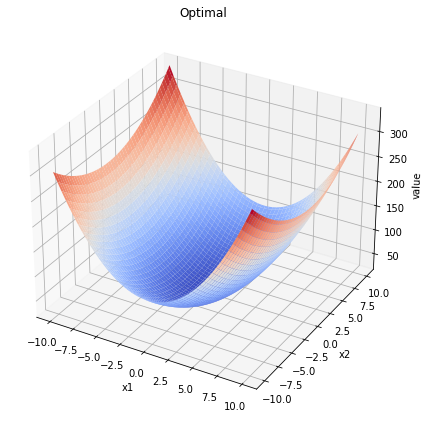

  0%|          | 0/100000 [00:00<?, ?it/s]

Final loss: 26.405921936035156
Best possible: 26.40592384338379


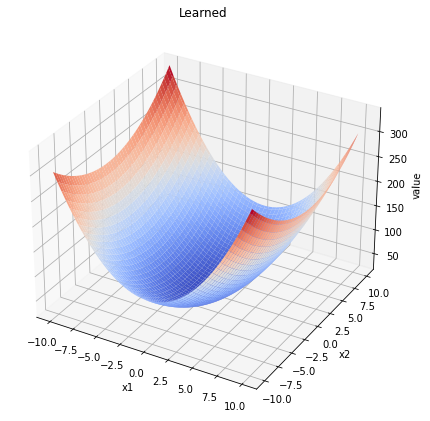

In [24]:
test_true_svg()